In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import skimage.io as io
from skimage.feature import hog
from skimage.transform import resize

from sklearn.model_selection import train_test_split
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Visualize some examples of HOG

In [2]:
DATA_DIR = './dataset/download/'

In [3]:
# image size to pass to HOG Algorithm
HOG_ROWS = 64
HOG_COLS = 128

In [4]:
tiki_label = pd.read_csv('./labels_tiki.csv', names=['label', 'x', 'y', 'w', 'h', 'img_name', 'raw_w', 'raw_h'])
tiki_label['img_path'] = tiki_label['img_name'].apply(lambda name: os.path.join(f'{DATA_DIR}/tiki', name))
tiki_label.head()

,label,x,y,w,h,img_name,raw_w,raw_h,img_path
0,tiki,3171,1344,592,389,img_0.png,5499,2582,./dataset/download//tiki/img_0.png
1,tiki,25,4,116,46,img_1.jpg,800,800,./dataset/download//tiki/img_1.jpg
2,tiki,362,42,100,43,img_1.jpg,800,800,./dataset/download//tiki/img_1.jpg
3,tiki,99,38,491,197,img_7.jpg,700,400,./dataset/download//tiki/img_7.jpg
4,tiki,28,38,32,24,img_8.jpg,600,315,./dataset/download//tiki/img_8.jpg


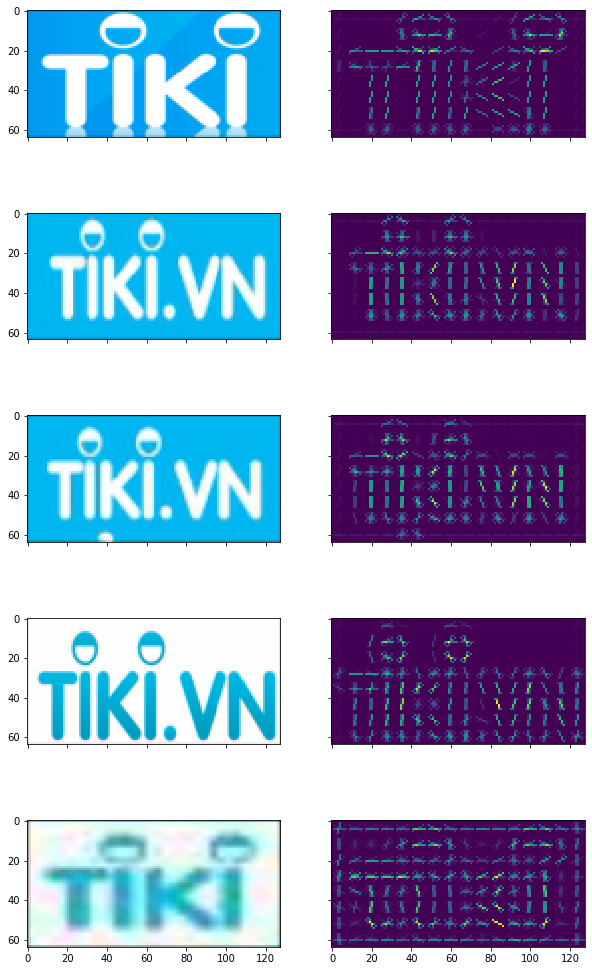

In [5]:
num_samples = 5
figure, axes = plt.subplots(len(tiki_label[:num_samples]), 2, sharex=True, sharey=True, figsize=(10, 18))

for i, box in enumerate(tiki_label[:num_samples].itertuples()):
    img = io.imread(box.img_path)
    box_x, box_y, box_w, box_h = box.x, box.y, box.w, box.h
                            
    crop = img[box_y:box_y+box_h, box_x:box_x+box_w, :]
    crop_resize = resize(crop, (HOG_ROWS, HOG_COLS), mode='constant')
                            
    hog_feature, visualize_img = hog(crop_resize, visualize=True)
    axes[i, 0].imshow(crop_resize)
    axes[i, 1].imshow(visualize_img)
    
plt.show()

In [6]:
vng_label = pd.read_csv('./labels_2.csv', names=['label', 'x', 'y', 'w', 'h', 'img_name', 'raw_w', 'raw_h'])
vng_label['img_path'] = vng_label['img_name'].apply(lambda name: os.path.join(f'{DATA_DIR}/vng', name))
vng_label.head()

,label,x,y,w,h,img_name,raw_w,raw_h,img_path
0,vng,149,12,186,232,img_0.jpg,484,252,./dataset/download//vng/img_0.jpg
1,vng,16,8,219,297,img_1.png,640,320,./dataset/download//vng/img_1.png
2,vng,141,98,344,477,img_6.jpg,1254,640,./dataset/download//vng/img_6.jpg
3,vng,341,7,246,294,img_7.png,640,320,./dataset/download//vng/img_7.png
4,vng,13,4,197,283,img_12.png,650,363,./dataset/download//vng/img_12.png


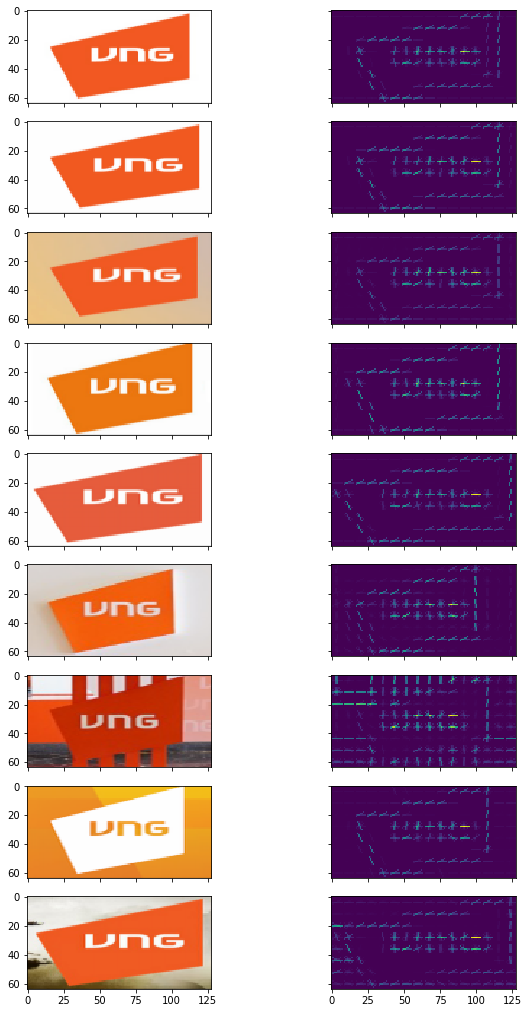

In [7]:
num_samples = 10
figure, axes = plt.subplots(len(vng_label[:num_samples]), 2, sharex=True, sharey=True, figsize=(10, 18))

for i, box in enumerate(vng_label[:num_samples].itertuples()):
    img = io.imread(box.img_path)
    box_x, box_y, box_w, box_h = box.x, box.y, box.w, box.h
                            
    crop = img[box_y:box_y+box_h, box_x:box_x+box_w, :]
    crop_resize = resize(crop, (HOG_ROWS, HOG_COLS), mode='constant')
                            
    hog_feature, visualize_img = hog(crop_resize, visualize=True)
    axes[i, 0].imshow(crop_resize)
    axes[i, 1].imshow(visualize_img)
    
plt.show()

# Prepare Data

In [8]:
all_data = pd.concat((tiki_label, vng_label))
all_data.head()

,label,x,y,w,h,img_name,raw_w,raw_h,img_path
0,tiki,3171,1344,592,389,img_0.png,5499,2582,./dataset/download//tiki/img_0.png
1,tiki,25,4,116,46,img_1.jpg,800,800,./dataset/download//tiki/img_1.jpg
2,tiki,362,42,100,43,img_1.jpg,800,800,./dataset/download//tiki/img_1.jpg
3,tiki,99,38,491,197,img_7.jpg,700,400,./dataset/download//tiki/img_7.jpg
4,tiki,28,38,32,24,img_8.jpg,600,315,./dataset/download//tiki/img_8.jpg


In [9]:
train_data, test_data = train_test_split(all_data)

In [10]:
train_data.columns

Index(['label', 'x', 'y', 'w', 'h', 'img_name', 'raw_w', 'raw_h', 'img_path'], dtype='object')

In [11]:
train_data_raw_X = train_data.drop('label', axis=1)
train_data_raw_Y = train_data['label']

test_data_raw_X = test_data.drop('label', axis=1)
test_data_raw_Y = test_data['label']

In [12]:
encoder = preprocessing.LabelEncoder()
train_data_Y = encoder.fit_transform(train_data_raw_Y)
test_data_Y = encoder.transform(test_data_raw_Y)

In [13]:
train_X = []
for box in train_data.itertuples():
    img = io.imread(box.img_path)
    box_x, box_y, box_w, box_h = box.x, box.y, box.w, box.h
                            
    crop = img[box_y:box_y+box_h, box_x:box_x+box_w, :]
    crop_resize = resize(crop, (HOG_ROWS, HOG_COLS), mode='constant')
                            
    hog_feature = hog(crop_resize, visualize=False)
    train_X.append(hog_feature)
train_data_X = np.array(train_X)

In [14]:
test_data_X = []
for box in test_data.itertuples():
    img = io.imread(box.img_path)
    box_x, box_y, box_w, box_h = box.x, box.y, box.w, box.h
                            
    crop = img[box_y:box_y+box_h, box_x:box_x+box_w, :]
    crop_resize = resize(crop, (HOG_ROWS, HOG_COLS), mode='constant')
                            
    hog_feature = hog(crop_resize, visualize=False)
    test_data_X.append(hog_feature)
test_data_X = np.array(test_data_X)

In [15]:
train_data_X.shape

(31, 6804)

In [16]:
train_data_Y.shape

(31,)

In [17]:
test_data_X.shape

(11, 6804)

In [18]:
test_data_Y.shape

(11,)

In [19]:
model = LogisticRegression()

In [20]:
model.fit(train_data_X, train_data_Y)

/home/vinhloi/anaconda3/envs/ds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
test_data_Y_hat = model.predict(test_data_X)

In [22]:
accuracy = accuracy_score(test_data_Y, test_data_Y_hat) * 100.0 # percent

In [23]:
print(accuracy)

100.0


# Visualize prediction

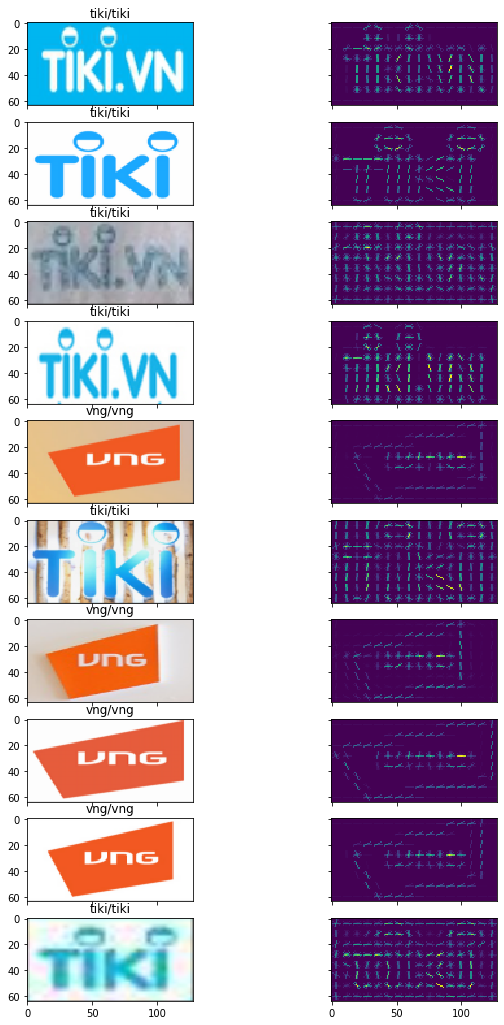

In [24]:
num_samples = 10
figure, axes = plt.subplots(len(test_data_raw_X[:num_samples]), 2, sharex=True, sharey=True, figsize=(10, 18))

for i, box in enumerate(test_data_raw_X[:num_samples].itertuples()):
    img = io.imread(box.img_path)
    box_x, box_y, box_w, box_h = box.x, box.y, box.w, box.h
                            
    crop = img[box_y:box_y+box_h, box_x:box_x+box_w, :]
    crop_resize = resize(crop, (HOG_ROWS, HOG_COLS), mode='constant')
                            
    hog_feature, visualize_img = hog(crop_resize, visualize=True)
    axes[i, 0].imshow(crop_resize)
    axes[i, 1].imshow(visualize_img)
    
    predict = encoder.inverse_transform(test_data_Y_hat[[i]])[0]
    groundtruth = encoder.inverse_transform(test_data_Y[[i]])[0]
    axes[i, 0].set_title(f'{predict}/{groundtruth}')
    
plt.show()